# SIMPLE WORKING VERSION - NOW CONVERTING TO BATCH

# RNN LSTM Chatbot project

In this project I'm creating a chatbot that is supposed to answer questions from the Stanford Questions & Answers dataset SQuAD1, using a sequence-to-sequence Encoder-Decoder recurrent neural network architecture in PyTorch.

To make the notebook more readable and the code more modular, all helper functions (data ingestion and preparation, data analysis, vocabulary creation) were moved to `modules`. 

The model for easier debugging is kept in the main notebook for now.



In [1]:
import torch

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda:0'

In [4]:
from torchtext.datasets import SQuAD1

In [5]:
train, test = SQuAD1("root")

In [6]:
from modules.data import *

#get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data ingestion

* Data is loaded from the dataset into pandas dataframes: one for training, one for testing, 
* To keep the dataset size reasonable, only a sample of the questions/answers is taken

In [7]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [8]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

In [9]:
train_len = 30000
test_len = 3000

In [10]:
train_df = sample_df_num(train_df, train_len)

In [11]:
test_df = sample_df_num(test_df, test_len)

In [12]:
train_df.shape, test_df.shape

((30000, 2), (3000, 2))

In [13]:
train_df.head(3)

,Question,Answer
0,How many awards at the Broadcast Film Critics ...,two
1,Which network in Australia offers viewers the ...,Foxtel
2,What form of due process was a harbinger of ou...,Provocatio


## Vocabulary creation / Data preparation

Sentences (questions and answers) are converted into lists of tokens:
* all characters are made into lower case
* punctuation is removed
* stopwords (most common words that don't carry much additional meaning) are removed, but keeping question words (when, how, who, etc.)
* For questions stemming is applied to reduce number of words to just their "roots". For answers this step is skipped, to have full unstemmed words in the answers vocabulary
* Pairs question:answer are created from both train and test dataset, and words are added to two vocabularies: Q_vocab and A_vocab

In [14]:
# Example of the sequence processing

import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

Who was the original lead singer of AC/DC who died?
['who', 'original', 'lead', 'singer', 'acdc', 'who', 'died']
['who', 'origin', 'lead', 'singer', 'acdc', 'who', 'die']


In [15]:
from modules.vocab import Vocab

In [16]:
for col, norm in zip(cols, ['stem', None]): # only questions get stemmed
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [17]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [18]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
26444,What group includes the symmetries of degree 4...,the dihedral group,"[what, group, includ, symmetri, degre, 4, deno...","[dihedral, group]"
16263,Where do the family of Michael Foot live?,Trematon Castle,"[where, famili, michael, foot, live]","[trematon, castle]"
20161,What two things do citizens have the right to ...,a constitutional initiative and a referendum,"[what, two, thing, citizen, right, submit, ove...","[constitutional, initiative, referendum]"


In [19]:
# processed sequences columns names have '_tokens' suffix
cols_tokens = [f'{col}_tokens' for col in cols]

### Create pairs and add to the vocabularies

In [20]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [21]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [22]:
Q_vocab, A_vocab = Vocab(), Vocab()

### Words from both training and test datasets are added to the two vocabularies

In [23]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [24]:
Q_vocab.n_words, A_vocab.n_words, 

(17037, 22305)

In [25]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [26]:
# Answers vocabulary contains more words due to lack of stemming

Q_vocab.n_words, A_vocab.n_words 

(18049, 23722)

## Data analysis and further cleanup

To improve and reduce the dataset, some analysis is done to find and remove outliers:
* least common words (those that occur only once)
* answers that have less than one token (empty sequences)
* questions that have less than three tokens, as they're not really meaningful
* histograms are used to find the "long tail" of the dataset: longer sequences are rare, so I establish a threshold above which the dataframe row with either very long question or answer is dropped. This way most of the data is kept, and the sequences can be of reasonable length

In [27]:
from modules.stats import sentences_stats, histograms

In [28]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.44
	         median: 6.00
	         minimum: 1
	         maximum: 24)
Sentences in column Answer_tokens:
	         mean: 2.41
	         median: 2.00
	         minimum: 0
	         maximum: 21)


In [29]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.55
	         median: 6.00
	         minimum: 2
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.37
	         median: 2.00
	         minimum: 0
	         maximum: 15)


### Remove the least common words from the sentences

In [30]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [31]:
print(f'Questions vocabulary has {len(get_outliers(Q_vocab, outlier_threshold+1))} words that occur only once, answers vocabulary has {len(get_outliers(A_vocab, outlier_threshold+1))} such words')

Questions vocabulary has 8971 words that occur only once, answers vocabulary has 14236 such words


### Create lists of those words and remove them from the sequences

In [32]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [33]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [34]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [35]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.17
	         median: 6.00
	         minimum: 1
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 1.98
	         median: 2.00
	         minimum: 0
	         maximum: 19)


In [36]:
# tokenized & least common removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.27
	         median: 6.00
	         minimum: 1
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 1.94
	         median: 2.00
	         minimum: 0
	         maximum: 14)


### Remove questions that have less than three words and answers that have less than one

In [37]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


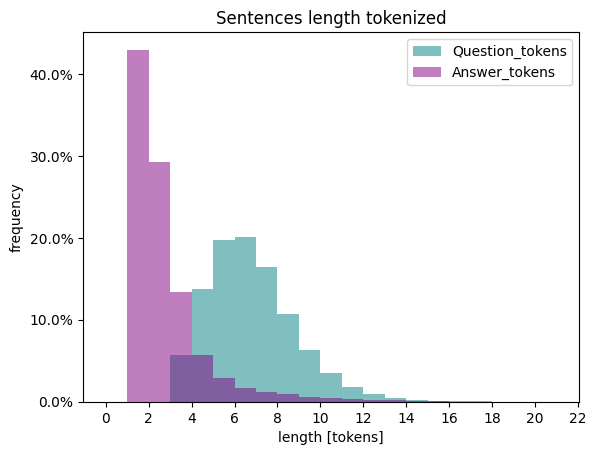

In [38]:
# display the histograms to see if that worked

train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [39]:
train_df_final.shape

(25710, 4)

In [40]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.28
	         median: 6.00
	         minimum: 3
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 2.26
	         median: 2.00
	         minimum: 1
	         maximum: 19)


In [41]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


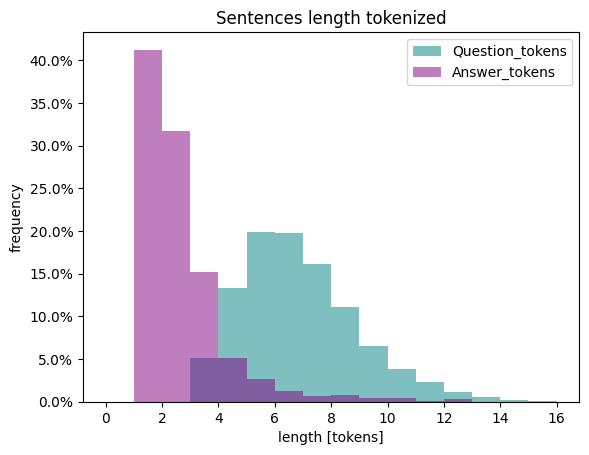

In [42]:
# display the histograms to see if that worked

test_df_final_thresholds = histograms(test_df_final, cols_tokens, name = 'tokenized')

In [43]:
test_df_final.shape

(2615, 4)

In [44]:
# shortest sentences removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.36
	         median: 6.00
	         minimum: 3
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.17
	         median: 2.00
	         minimum: 1
	         maximum: 14)


### Remove long outliers: long sentences that occure rarely

In [45]:
# keeping only the 95% of the data
cutoff = 95

In [46]:
get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [47]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [48]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [49]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.08
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.98
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [50]:
# to simplify I'm using the same thresholds for the test set

In [50]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [51]:
# long outliers removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.14
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.97
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [52]:
train_df_final.shape, test_df_final.shape

((23787, 4), (2424, 4))

### Pairs have to be redone from the cleaned up datasets, to be used in the model (after being turned into tensors).

In [53]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [54]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [55]:
len(train_pairs_final), len(test_pairs_final)

(23787, 2424)

### Data preparation for the neural network model

Sequences are converted into torch tokens made of their vocabulary indexes. Sequences shorter than the defined length are padded at the beginning. Also Start-Of-Sequence and End-Of-Sequence tokens are added to the tensor.

The padding token will be ignored by the model.

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



In [56]:
import torch
import torch.nn as nn

## ENCODER

In [69]:
class Encoder(nn.Module):
    """
        Inputs:
            input_size: size of the vocabulary
            hidden_size: of the LSTM
            embedding_dim: embedding dimension
            lstm_layer: Default = 1
            dropout: Default = 0.5
    """        
    def __init__(self, input_size, hidden_size, embedding_size, lstm_layer=1, dropout = 0.5, batch_size = 1):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        # self.input_size = input_size
        # self.embedding_size = embedding_size
        self.lstm_layer = lstm_layer
        self.batch_size = batch_size

        # embedding step
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        # single LSTM layer
        self.lstm = nn.LSTM(embedding_size, self.hidden_size, num_layers = self.lstm_layer, batch_first = True, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, encoder_input):
        """
            Inputs:
                encoder_input: the src vector
            Outputs:
                hidden: the hidden state
                cell: the cell state
        """
        
        # embeds the input sequence using an embedding layer of size (input_size, embedding_size)
        
        embedded = self.embedding(encoder_input)
        embedded = self.dropout(embedded)        
        outputs, (hidden, cell_state) = self.lstm(embedded)
        return hidden, cell_state

## DECODER

In [64]:
class Decoder(nn.Module):
    
    """
        Inputs:
            input_size: size of the input vocabulary
            hidden_size: of the LSTM
            output_size: size of the output vocabulary
            embedding_size: embedding dimension
            lstm_layer: number of lstm layers Default = 1
            dropout: Default = 0.5
    """
    
    def __init__(self, input_size, hidden_size, output_size, embedding_size, lstm_layer = 1, dropout = 0.5):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm_layer = lstm_layer
        
        #self.embedding_size = embedding_size

        # embedding
        self.embedding = nn.Embedding(input_size, embedding_size)

        # single LSTM layer
        self.lstm = nn.LSTM(embedding_size, self.hidden_size, num_layers = self.lstm_layer, dropout=dropout)
        
        # fully connected linear layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
        self.dropout = nn.Dropout(dropout)
        
        # softmax
        self.softmax = nn.LogSoftmax(dim=1)     

    def forward(self, decoder_input, hidden, cell_state):
        
        """
            Inputs:
                decoder_input: previous token in the sequence
                hidden: previous hidden the state
                cell: previous cell state
            Outputs:
                prediction: the prediction
                hidden: the hidden state
                cell: the cell state
        """
        
        # decoder_input shape is torch.Size([batch_size]) - CHECK!
        # add time dimension of size 1
        
        decoder_input = decoder_input.unsqueeze(0)
        
        # now it should be torch.Size([1, batch_size]) - CHECK!
        # embeds the input token using an embedding layer of size (input_size, hidden_size)
        
        embedded = self.embedding(decoder_input)
        embedded = self.dropout(embedded)
        
        output, (hidden, cell_state) = self.lstm(embedded, (hidden, cell_state))
        
        # torch.Size([1, batch_size, hidden_size]) - CHECK!
        # prediction - remove the time dimension:
        output = self.fc(output.squeeze(0))
        
        # torch.Size([batch_size, vocab_size]) - what's vocab size???
        
        output = self.softmax(output)
        
        # check output size
        
        return output, hidden, cell_state
        

## SEQ2SEQ

In [65]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder, device):
        #super(Seq2Seq, self).__init__()
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
                
    def forward(self, src, trg = None, teacher_forcing_ratio: float = 0.5, max_len: int = 10):
        
        """
        Inputs:
            src: source sequence tensor of shape (batch_size, src_len)
            trg: target sequence tensor of shape (batch_size, trg_len) or None for inference
            teacher_forcing_ratio: probability of using teacher forcing
            max_len: maximum length of output (for inference only)
        
        Outputs:
            outputs: decoder outputs tensor of shape (batch_size, trg_vocab_size, trg_len)        
        """
        
        # target batch (answers) is unpacked to maximum length and batch size
        
        batch_size, trg_length = trg.shape if trg is not None else src.shape
        trg_length = trg_len if trg is not None else max_len
        
        trg_vocab_size = self.decoder.output_size
        
        # tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_vocab_size, trg_len).to(self.device)
        
        # last hidden state and cell state of the encoder as initial hidden and cell state for the decoder
        hidden, cell_state = self.encoder(src)
        
        # use the <SOS> token as the initial decoder input (vocab 0 = <SOS>)
        inp = torch.zeros(batch_size).to(self.device, dtype = torch.long)
        
        # use the first target token as the initial decoder input
        # inp = trg[:, 0]
        
        for t in range(trg_len):
            output, hidden, cell_state = self.decoder(inp, hidden, cell_state)
            
            # output shape is torch.Size([batch_size, vocab_size])  - CHECK!
            outputs[:, :, t] = output
            
            # torch.Size([batch_size, vocab_size, trg_len])
            if random.random() < teaching:
                # teacher forcing: use ground truth target token
                inp = trg[:, t]
            else:
                # use predicted token as input for next step
                inp = output.argmax(dim = 1)
        
        
        return outputs
        

### Model parameters

In [66]:
# define parameters
# input_size = len(v.words)

input_size=Q_vocab.n_words

# output_size = len(v.words)

output_size=A_vocab.n_words

embedding_size = 300
hidden_size = 512
lstm_layer = 2
dropout = 0.3
learning_rate = 0.02
epochs = 200
clip = 1  # something between 1 and 5 as a starting point
BATCH_SIZE = 64
teaching_ratio = 0.5

In [98]:
input_size, output_size

(18049, 23722)

In [70]:
#from dataset_helper import get_dataloader
#from encoder import Encoder
#from decoder import Decoder
#from seq2seq import Seq2Seq
#import torch

#train_dataloader, test_dataloader, valid_dataloader = get_dataloader(train_set, test_set, valid_set, BATCH_SIZE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate encoder and decoder classes
enc = Encoder(input_size, hidden_size, embedding_size, lstm_layer, dropout, BATCH_SIZE).to(device)
dec = Decoder(input_size, hidden_size, output_size, embedding_size, lstm_layer, dropout).to(device)
# instantiate seq2seq model
model = Seq2Seq(enc, dec, device).to(device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18049, 300)
    (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18049, 300)
    (lstm): LSTM(300, 512, num_layers=2, dropout=0.3)
    (fc): Linear(in_features=512, out_features=23722, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (softmax): LogSoftmax(dim=1)
  )
)


###  in Karan's example the input and output sizes are identical, why? using the same vocab?

embedding_dim = 512
hidden_size = 512

### Hyperparameters

learning_rate = 0.001
num_epochs = 25

### Model

seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

seq2seq = seq2seq.to(device)

### Optimizer and loss function

In [71]:
from torch import optim
import torch.nn as nn

In [72]:
#optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.NLLLoss(ignore_index=0) # 0 is padding

### Model training 

For debugging purposes the training function is kept in the main notebook for now.

In [88]:
total_train_loss = []
total_test_loss = []

## DATALOADER

I'm creating a very simple Dataset class, that can be then used by the DataLoader.

In [100]:
from torch.utils.data import DataLoader, Dataset

In [101]:
class MyDataset(Dataset):
    def __init__(self, pairs):
        
        '''
        Input: pairs of padded sequences converted to tensors
        '''
        
        self.source_data = [p.question for p in pairs]
        self.target_data = [p.answer for p in pairs]
            
    def __getitem__(self, idx):
        return self.source_data[idx], self.target_data[idx]
    
    def __len__(self):
        return len(self.source_data)

In [102]:
def collate_batch(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return torch.Tensor(data).to(torch.int64), torch.Tensor(target).to(torch.int64)

## New pairs creating function

In [75]:
def to_tensor_new(vocab, tokens, seq_len, padding):
    '''Converts a tokenized sentence into a tensor of indices of a given length.
    Allows to choose to pad either at the beginning or at the end.
    Padding at the beginning is the default option.'''
    
    tokens = [t for t in tokens if t in vocab.word2count.keys()]
    
    if padding == 'end':
    
        padded = [[vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']] + [vocab.word2index['PAD']] * (seq_len-len(tokens))]
        
    else:
    
        padded = [vocab.word2index['PAD']] * (seq_len-len(tokens)) + [vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']]

    tensor = torch.Tensor(padded).long().view(-1,1)
    
    return tensor

## MODIFICATIONS

Instead of using the named tuple for creating pairs from a dataframe, the token lists can be simply added as new columns in the dataframe. Probably the _to_tensor_new_ function needs to be modified as well (the SRC and TRG columns seem to contain simple lists of ints?)

In [76]:
Pair = namedtuple('Pair', ['question', 'answer'])
def get_tensor_pairs_from_df(df, cols, q_vocab, q_max_len, a_vocab, a_max_len, padding):
    '''returns a list of named tuples (question, answer)'''
    dicts = []
    for col in cols:
        dicts.append(df[col].to_dict().values())
    
    return [Pair(to_tensor_new(q_vocab, q, q_max_len, padding), to_tensor_new(a_vocab, a, a_max_len, padding)) for q, a in zip(*dicts)]

In [77]:
train_tensor_pairs_final = get_tensor_pairs_from_df(train_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX, 'end')

In [78]:
test_tensor_pairs_final = get_tensor_pairs_from_df(test_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX, 'end')

In [79]:
train_dataset = MyDataset(train_tensor_pairs_final)

In [80]:
test_dataset = MyDataset(test_tensor_pairs_final)

In [103]:
train_dataset

In [104]:
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True, collate_fn = collate_batch)

In [105]:
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = True, drop_last = True, collate_fn = collate_batch)

In [106]:
len(train_dataloader) # how many batches

371

In [107]:
len(test_dataloader) # how many batches

37

In [76]:
BATCH_SIZE = 1024

## DataLoader

In [81]:
train_dl = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [82]:
test_dl = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [108]:
def train_loop(model, train_dl, test_dl, optimizer, criterion, scheduler, clip, teaching_ratio, device, num_epochs, model_path):
    
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        
        train_loss = train(model, train_dl, optimizer, criterion, clip, teaching_ratio, device)
        
        # update best lost so far and save the model state if improved
        if train_loss < best_loss: 
            best_loss = train_loss
            torch.save(model.state_dict(), model_path)
        
        # execute step for learning rate scheduler based on validation loss
        scheduler.step(train_loss)
        
        # print the results
        
        print(f'Epoch: {epoch:3d} \t', f'Train loss: {train_loss:.3f} |\t', f'learning rate: {optimizer.param_groups[0]["lr"]}')

In [109]:
def train(model, iterator, optimizer, criterion, clip, teaching_ratio, device):
    
    # put model in training mode
    model.train()
    
    epoch_loss = 0
    
    for step, (src, trg) in enumerate(iterator):
         
        # check the sizes
        print(f'Source: {src.shape} |\tTarget {trg.shape}')
        
        src = src.to(device)
        trg = trg.to(device)
        
        # reset gradient
        optimizer.zero_grad()
        
        # run seq2seq model
        output = model(src, trg, teacher_forcing_ratio = teaching_ratio)
        
        # calculate loss
        # transpose dimensions 1 and 2 as in the example
        outputs_permuted = output.permute(0,2,1)
        # make memory layout contiguous
        outputs_contig = outputs_permuted.contiguous()
        # now a flattened vector is needed, of shape (batch_size * trg_len, trg_vocab_size)
        outputs_flatten = outputs.contig.view(-1, outputs_contig.size(-1))
        # the trg tensor is flattened to a 1-dimensional tensor of shape (batch_size * trg_len,)
        trg_flatten = trg.view(-1)
        loss = criterion(outputs_flatten, trg_flatten)
        loss.backward()
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)
        

In [110]:
def evaluate(model, iterator, criterion, device):
    
    # put model in evaluation mode
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():        
        for step, (src, trg) in enumerate(iterator):        
            src = src.to(device)
            trg = trg.to(device)
        
            # run seq2seq model
            output = model(src, trg, teacher_forcing_ratio = 0) # turned off for evaluation
        
            # calculate loss
            # transpose dimensions 1 and 2 as in the example
            outputs_permuted = output.permute(0,2,1)
            # make memory layout contiguous
            outputs_contig = outputs_permuted.contiguous()
            # now a flattened vector is needed, of shape (batch_size * trg_len, trg_vocab_size)
            outputs_flatten = outputs.contig.view(-1, outputs_contig.size(-1))
            # the trg tensor is flattened to a 1-dimensional tensor of shape (batch_size * trg_len,)
            trg_flatten = trg.view(-1)
            loss = criterion(outputs_flatten, trg_flatten)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def train(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio = 0.5, print_every = 1000): 
    
    model.train() # Set the model to training mode

    total_loss = 0

    count = 0

    for batch in dataloader:

        src_tensor, tgt_tensor = batch # get question and answer tensors from the batch
                
        src_tensor, tgt_tensor = src_tensor.to(device), tgt_tensor.to(device) # move them to the device

        src_tensor, tgt_tensor = src_tensor.reshape(-1,1), tgt_tensor.reshape(-1,1) # reshape to a two-dimensional tensor to feed the Seq2Seq class
                
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=teacher_forcing_ratio)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        count += 1 

        if count % print_every == 0:
            print(f'Loss {total_loss/count}')

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
        
        for batch in dataloader:

            src_tensor, tgt_tensor = batch

            src_tensor, tgt_tensor = src_tensor.to(device), tgt_tensor.to(device)

            src_tensor, tgt_tensor = src_tensor.reshape(-1,1), tgt_tensor.reshape(-1,1)

            output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=0) # turn off teacher forcing

            # Compute the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
            
            total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [93]:
import matplotlib.pyplot as plt

In [111]:
import torch.optim.lr_scheduler as lr_scheduler

# lr scheduler to see if this improves the performance of the validation loss
lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

In [112]:
model_out_path = 'my_model.pt'

In [114]:
# train loop
train_loop(model, train_dataloader, test_dataloader, optimizer, criterion, lr_scheduler, clip, teaching_ratio, device, epochs, model_out_path)

ValueError: only one element tensors can be converted to Python scalars

# ERRORS:

~* too many values to unpact, expected 2 - what is trg.shape? or src.shape?~
* only one element tensors can be converted to python scalars: what's the data and target size for the collate_fn function? - the dataset is created with train_set['SRC'] and train_set['TRG'] - those are columns of dataframes, and in my code the dataset is made of single tensors

In [115]:
train_df_final.head(3)

,Question,Answer,Question_tokens,Answer_tokens
3,Where did John Smyth go into exile?,Amsterdam,"[where, john, smyth, go, exil]",[amsterdam]
4,When did the French authorities adopted the pr...,Since the presidency of François Mitterrand (1...,"[when, french, author, adopt, unif, posit]","[since, presidency]"
5,What did a 4 July 2003 front page story claim?,asylum seekers were slaughtering and eating swans,"[what, 4, juli, 2003, front, page, stori, claim]","[asylum, eating]"


In [89]:
for epoch in range(epochs):
    train_loss = train(model, train_dl, optimizer, criterion, device)
    test_loss = evaluate(model, test_dl, criterion, device)    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)



TypeError: forward() got an unexpected keyword argument 'src_len'

# STOPPING AFTER 10 EPOCHS - NOT CONVERGING

In [100]:
N_EPOCHS = 10

Text(0, 0.5, 'loss')

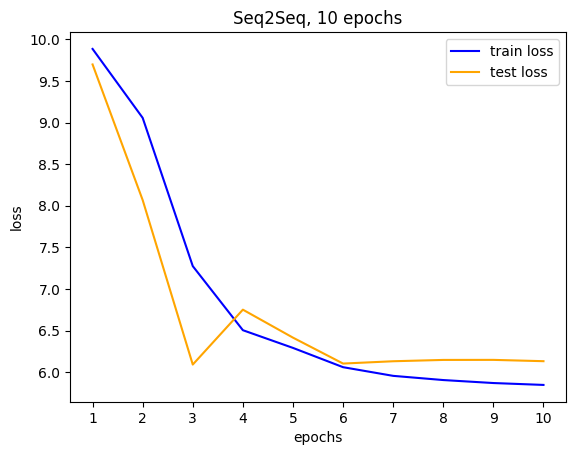

In [101]:
fig, ax = plt.subplots()
ax.plot(range(1, N_EPOCHS+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, N_EPOCHS+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {N_EPOCHS} epochs')
ax.set_xticks(range(1, N_EPOCHS+1))
ax.set_xlabel('epochs')
ax.set_ylabel('loss')